## <center> Packages <center>

In [1]:
from tests_impl import *
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from non_partial_monte_carlo import *


# import warnings
# warnings.filterwarnings("ignore")

## <center> 1.1. Relevance Test [Done] <center>

In [3]:
# see test_impl: unconditional_relevance

## <center> 1.2 Simulation and sanity check [Need to monte-carlo model] <center>

In [7]:
sets_of_f2_indices = [
    [0],
    [1],
    [2],
    [3],
    [4],
    [0, 1, 4],
    [2, 3],
]

result = monte_carlo_conditional_relevance_prodecure(
    T=10,
    beta=0.98, 
    gamma=1.5,
    sets_of_f2_indices=sets_of_f2_indices,
    B=16,
    num_alphas=1000,
    n_jobs=-1,
)

simulating many times:   0%|          | 0/16 [00:00<?, ?it/s]

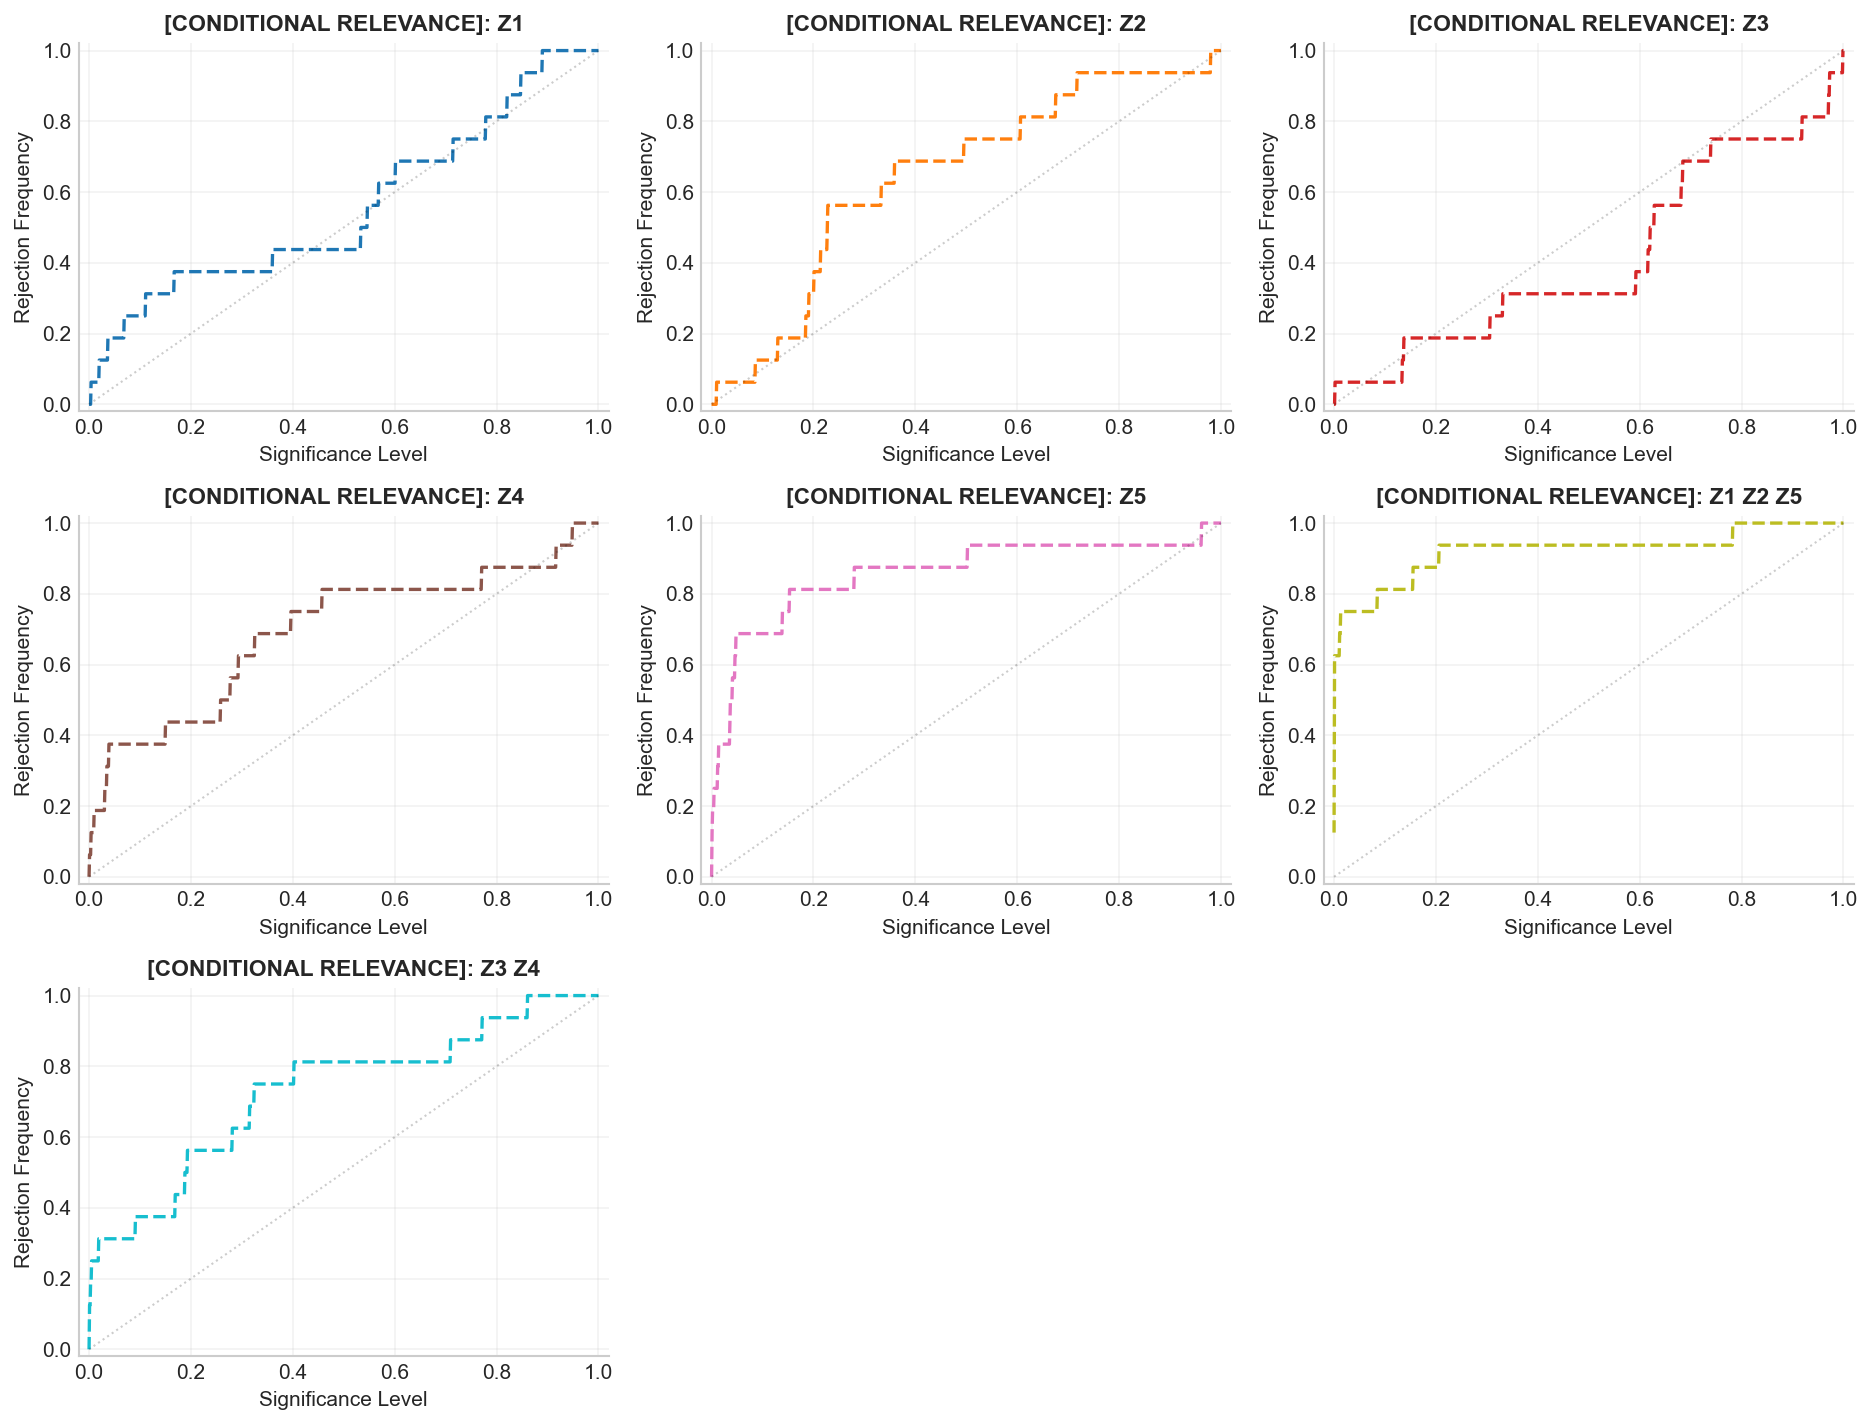

In [8]:
plot_rejection_curves(result, save_path="report.png")

In [10]:
def logistic(x): 
    return 1.0 / (1.0 + anp.exp(-x))

def standardize(z):
    return z

def simulate_ccapm_structured(T=800, seed=2025):
    rng = np.random.default_rng(seed)
    # состояние
    phi_s, sigma_s = 0.9, 0.7
    s = np.zeros(T)
    for t in range(1, T):
        s[t] = phi_s * s[t-1] + rng.normal(scale=sigma_s)

    rho = 0.3
    eps = rng.normal(size=(T,2))
    eps[:,1] = rho*eps[:,0] + np.sqrt(1-rho**2)*eps[:,1]

    mu_c, ac, sig_c = 0.003, 0.015, 0.020 
    mu_r, ar, sig_r = 0.010, 0.150, 0.050
    g_tp1      = mu_c + ac*s + sig_c*eps[:,0]
    rlog_tp1   = mu_r + ar*s + sig_r*eps[:,1]

    C = np.zeros(T+1); C[0] = 1.0
    for t in range(T):
        C[t+1] = C[t] * np.exp(g_tp1[t])
    Ct, Ctp1 = C[:-1], C[1:]
    Rtp1     = np.exp(rlog_tp1)

    # инструменты на t
    const    = np.ones(T)
    z_state  = standardize(s)       
    g_t      = np.concatenate([[g_tp1[0]], g_tp1[:-1]])   
    z_c_lag  = standardize(np.exp(g_t))                   
    z_weak   = standardize(0.2*z_state + rng.normal(scale=0.8, size=T))
    z_noise  = standardize(rng.normal(size=T))          
    z_noise2 = standardize(rng.normal(size=T))        

    data = {
        'Ct': Ct, 'Ctp1': Ctp1, 'Rtp1': Rtp1,
        'const': const, 'z_state': z_state, 'z_c_lag': z_c_lag,
        'z_weak': z_weak, 'z_noise': z_noise, 'z_noise2': z_noise2
    }
    return data

def ccapm_moment_factory(z_key: str) -> Callable:
    def moment(theta, dp: Dict[str, Any]):
        beta  = logistic(theta[0]) 
        gamma = anp.exp(theta[1])
        core  = beta * (dp['Ctp1']/dp['Ct'])**(-gamma) * dp['Rtp1'] - 1.0
        return dp[z_key] * core
    return moment

def build_ccapm_moments(instrument_keys: List[str]) -> List[Callable]:
    return [ccapm_moment_factory(z) for z in instrument_keys]

def run_uncond_one(data, moments, instrument_keys, cand_name, theta_init, expect_relevant: bool):
    idx = [instrument_keys.index(cand_name)]
    res = unconditional_relevance(
        data=data,
        moments=moments,
        f2_indexes=idx,
        theta_init=theta_init
    )
    W, p = (res[0], res[1]) if isinstance(res, tuple) and len(res)>=2 else (float(res), np.nan)
    got_rel = (p < 0.05)
    exp_txt = "ожидаем: РЕЛЕВАНТЕН " if expect_relevant else "ожидаем: нерелевантен"
    got_txt = f"получили: p={p:.4f} ({'релевантен' if got_rel else 'нерелевантен'})"
    status  = "OK" if got_rel == expect_relevant else "MISMATCH"
    print(f"{cand_name:10s} | W={W:9.3f} | {exp_txt:18s} | {got_txt:36s} | {status}")
    return W, p

def run_uncond_group(data, moments, instrument_keys, group_names, theta_init, expect_relevant: bool):
    idxs = [instrument_keys.index(nm) for nm in group_names]
    res = unconditional_relevance(
        data=data,
        moments=moments,
        f2_indexes=idxs,
        theta_init=theta_init
    )
    W, p = (res[0], res[1]) if isinstance(res, tuple) and len(res)>=2 else (float(res), np.nan)
    got_rel = (p < 0.05)
    label = "+".join(group_names)
    exp_txt = "ожидаем: РЕЛЕВАНТЕН " if expect_relevant else "ожидаем: нерелевантен"
    got_txt = f"получили: p={p:.4f} ({'релевантен' if got_rel else 'нерелевантен'})"
    status  = "OK" if got_rel == expect_relevant else "MISMATCH"
    print(f"{label:20s} | W={W:9.3f} | {exp_txt:18s} | {got_txt:36s} | {status}")
    return W, p

if __name__ == "__main__":
    data = simulate_ccapm_structured(T=200, seed=100)
    instrument_keys = ['const', 'z_state', 'z_c_lag', 'z_weak', 'z_noise', 'z_noise2']
    moments = build_ccapm_moments(instrument_keys)

    def logit(p): return np.log(p) - np.log(1-p)
    theta_init = np.array([logit(0.97), np.log(5.0)], dtype=float)

    print("Unconditional relevance (H0: G2 = 0), df = m2*k = 1*2 = 2")
    print("- Индивидуальные тесты:\n")

    expect_single = {
        'const':   True,   # β
        'z_state': True,   # напрямую через s_t
        'z_c_lag': True,   # через AR-связь
        'z_weak':  True,   # слабый, но релевантный
        'z_noise': False,  # шум
        'z_noise2': False  # шум
    }
    for name in instrument_keys:
        run_uncond_one(data, moments, instrument_keys, name, theta_init, expect_single[name])

    print("\n- Групповые тесты:\n")
    group_tests = [
        (['z_state', 'z_c_lag'],            True),   # сильная пара по состоянию
        (['z_noise', 'z_noise2'],           False),  # два шума
        (['z_state', 'z_noise'],            True),   # релевантный + шум
        (['z_c_lag', 'z_weak'],             True),   # средняя сила
        (['z_weak', 'z_noise2'],            True),   # слабый + шум
        (['const', 'z_noise'],              True),   # константа всегда «тянет»
        (['z_state', 'z_c_lag', 'z_weak'],  True),   # сильная тройка
    ]
    for names, exp in group_tests:
        run_uncond_group(data, moments, instrument_keys, names, theta_init, expect_relevant=exp)

Unconditional relevance (H0: G2 = 0), df = m2*k = 1*2 = 2
- Индивидуальные тесты:

const      | W=   45.930 | ожидаем: РЕЛЕВАНТЕН  | получили: p=0.0000 (релевантен)      | OK
z_state    | W=   58.549 | ожидаем: РЕЛЕВАНТЕН  | получили: p=0.0000 (релевантен)      | OK
z_c_lag    | W=   47.736 | ожидаем: РЕЛЕВАНТЕН  | получили: p=0.0000 (релевантен)      | OK
z_weak     | W=   12.032 | ожидаем: РЕЛЕВАНТЕН  | получили: p=0.0024 (релевантен)      | OK
z_noise    | W=    1.327 | ожидаем: нерелевантен | получили: p=0.5151 (нерелевантен)    | OK
z_noise2   | W=    1.337 | ожидаем: нерелевантен | получили: p=0.5125 (нерелевантен)    | OK

- Групповые тесты:

z_state+z_c_lag      | W=   61.745 | ожидаем: РЕЛЕВАНТЕН  | получили: p=0.0000 (релевантен)      | OK
z_noise+z_noise2     | W=    2.874 | ожидаем: нерелевантен | получили: p=0.5792 (нерелевантен)    | OK
z_state+z_noise      | W=   58.591 | ожидаем: РЕЛЕВАНТЕН  | получили: p=0.0000 (релевантен)      | OK
z_c_lag+z_weak       | W=   50.509 

## <center> 2.1. Conditional Relevance [Done] <center>

In [8]:
# see test_impl: conditional_relevance

## <center> 2.2 Simulation and sanity check [Need to monte-carlo model] <center>

In [19]:
T = 600
rng = np.random

z1_raw = rng.normal(size=T)
z2_raw = rng.normal(size=T)
def standardize(z):
    zc = z - z.mean()
    s = zc.std(ddof=1)
    return zc / s if s > 0 else zc

z1 = standardize(z1_raw)
z2 = standardize(z2_raw)
v  = rng.normal(scale=0.7, size=T)
x_raw  = 0.8*z1 + 0.8*z2 + v
x = standardize(x_raw)

alpha_true, beta_true, gamma_true = -0.4, 1.0, -0.7
linidx = alpha_true + beta_true*x + gamma_true*(x**2)

def sigmoid_stable(u):
    return 0.5 * (1.0 + anp.tanh(0.5 * u))

p = 1.0 / (1.0 + np.exp(-linidx))
y = rng.binomial(1, p, size=T)

z_nl   = standardize(z1**2 + z2**2)
z_red  = standardize(0.7*z1 + 0.3*z2 + 0.02*rng.normal(size=T))
z_noise = standardize(rng.normal(size=T))
const  = np.ones(T)

data: Dict[str, np.ndarray] = {
    'y': y, 'x': x,
    'const': const, 'z1': z1, 'z2': z2,
    'z_nl': z_nl, 'z_red': z_red, 'z_noise': z_noise
}

def make_moment(name: str) -> Callable:
    def moment(theta, dp: Dict[str, Any]):
        lin = theta[0] + theta[1]*dp['x'] + theta[2]*(dp['x']**2)
        mu = 0.5 * (1.0 + anp.tanh(0.5 * lin))
        return dp[name] * (dp['y'] - mu)
    return moment

instr_order = ['const', 'z1', 'z2', 'z_nl', 'z_red', 'z_noise']
moments = [make_moment(k) for k in instr_order]

theta_init = np.array([0.0, 0.2, -0.2], dtype=float)

def run_cond_test(label: str, expect_significant: bool):
    idx = [instr_order.index(label)]
    W, pval, theta_hat = conditional_relevance(
        data=data,
        moments=moments,
        f2_indexes=idx,
        theta_init=theta_init,
        verbose=False
    )
    got_significant = (pval < 0.05)
    exp_txt = "ожидаем: релевантен (p<0.05)" if expect_significant else "ожидаем: нерелевантен (p>=0.05)"
    got_txt = f"получили: p={pval:.4f} ({'релевантен' if got_significant else 'нерелевантен'})"
    status = "OK" if got_significant == expect_significant else "MISMATCH"
    print(f"{label:8s} | W={W:9.3f} | {exp_txt:32s} | {got_txt:36s} | θ̂=({theta_hat[0]:.3f},{theta_hat[1]:.3f},{theta_hat[2]:.3f}) | {status}")
    return W, pval, theta_hat

print("Условная релевантность (H0: GΔ = 0), df = m2*k = 1*3 = 3")
print("- Кандидаты тестируются «сверх» базы {const, z1, z2}.\n")

run_cond_test('z_nl',   expect_significant=True)

run_cond_test('z_red',  expect_significant=False)

run_cond_test('z_noise', expect_significant=False)

Условная релевантность (H0: GΔ = 0), df = m2*k = 1*3 = 3
- Кандидаты тестируются «сверх» базы {const, z1, z2}.

z_nl     | W=   17.026 | ожидаем: релевантен (p<0.05)     | получили: p=0.0007 (релевантен)      | θ̂=(-0.469,1.260,-0.805) | OK
z_red    | W=    1.068 | ожидаем: нерелевантен (p>=0.05)  | получили: p=0.7847 (нерелевантен)    | θ̂=(-0.469,1.260,-0.805) | OK
z_noise  | W=    4.166 | ожидаем: нерелевантен (p>=0.05)  | получили: p=0.2440 (нерелевантен)    | θ̂=(-0.469,1.260,-0.805) | OK


(4.166389549002608,
 0.244048545382201,
 array([-0.46878286,  1.26018516, -0.80546778]))

## <center> <center>

## <center> 3.1. Partial Relevance Test <center>

In [216]:
# see test_impl: partial_unconditional_relevance

## <center> 3.2 Simulation and sanity check [Need to monte-carlo model] <center>

In [299]:
import numpy as np
from scipy.stats import chi2

###########################################################
# 1. Генератор данных — простая IV модель
###########################################################


###########################################################
# 2. Фабрика моментных условий m = z * (y - x @ theta)
###########################################################
# simulate_linear_iv: добавляем z3
def simulate_linear_iv(T, beta, rho_zx=0.0, sigma_u=1.0, z3_strength=0.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    w   = np.random.normal(size=T)            # candidate instrument z2
    z1  = np.ones(T)                          # z1 — константа
    eps = np.random.normal(size=T)
    x1 = rho_zx * w + np.sqrt(max(0.0, 1 - rho_zx**2)) * eps
    # z3: можно сделать независимым шумом (нерелевантный) или скоррелировать с x (релевантный)
    v = np.random.normal(size=T)
    z3 = z3_strength * w + np.sqrt(max(0.0, 1 - z3_strength**2)) * v
    u  = np.random.normal(scale=sigma_u, size=T)
    y  = beta[0] + beta[1] * x1 + u
    return {'y': y, 'x0': np.ones(T), 'x1': x1, 'z1': z1, 'z2': w, 'z3': z3}

# make_moments: используем три инструмента
def make_moments(z_keys=('z1','z2','z3')):
    def make_mom(zkey):
        def mom(theta, dp):
            x = np.array([dp['x0'], dp['x1']])
            resid = dp['y'] - x.dot(theta)
            return dp[zkey] * resid
        return mom
    return [make_mom(z) for z in z_keys]



###########################################################
# 3. Monte-Carlo для partial_unconditional_relevance
###########################################################
def mc_partial_unconditional(
    partial_unconditional_relevance,
    N=500,
    T=300,
    beta=(1.0,2.0),
    rhos=(0.8, 0.2, 0.0),
    alpha=0.05,
    theta_init=np.array([0.0,0.0]),
    verbose=False
):
    """
    N — прогонов на каждую величину rho_zx.
    rhos — список сценариев:
        0.8 — сильный инструмент
        0.2 — слабый
        0.0 — нерелевантный

    Для каждого случая считаем:
      - частоту отклонения на A={slope}
      - частоту отклонения на A={intercept}
      - средние оценки theta и p-values
    """
    results = {}

    # моментные условия: z1,z2
    moments = make_moments(('z1','z2','z3'))

    # тестироваться будут моменты f2 = z2
    f2_indexes = [1]

    # два варианта A:
    A_slope     = [1]   # параметр beta1
    A_intercept = [0]   # параметр beta0

    for rho in rhos:
        key = f"rho = {rho:.2f}"
        rej_slope     = []
        rej_intercept = []
        theta_list    = []
        W_list_slope  = []
        p_list_slope  = []

        for _ in tqdm(range(N)):
            # генерируем данные
            data = simulate_linear_iv(
                T=T,
                beta=beta,
                rho_zx=rho,
                sigma_u=1.0,
                seed=None
            )

            # тест по slope
            # try:
            W_s, p_s, th_s = partial_unconditional_relevance(
                data=data,
                moments=moments,
                f2_indexes=f2_indexes,
                a_indexes=A_slope,
                theta_init=theta_init,
                verbose=verbose
            )
            # except Exception:
            #     W_s, p_s, th_s = np.nan, np.nan, np.array([np.nan, np.nan])

            # тест по intercept
            # try:
            W_i, p_i, th_i = partial_unconditional_relevance(
                data=data,
                moments=moments,
                f2_indexes=f2_indexes,
                a_indexes=A_intercept,
                theta_init=theta_init,
                verbose=verbose
            )
            # except Exception:
            #     W_i, p_i, th_i = np.nan, np.nan, np.array([np.nan, np.nan])

            # собираем
            rej_slope.append(     (p_s < alpha) if not np.isnan(p_s) else False )
            rej_intercept.append( (p_i < alpha) if not np.isnan(p_i) else False )
            theta_list.append(th_s)
            W_list_slope.append(W_s)
            p_list_slope.append(p_s)

        theta_arr = np.vstack(theta_list)

        results[key] = {
            'rho'                 : rho,
            'reject_rate_slope'   : np.mean(rej_slope),
            'reject_rate_intercept': np.mean(rej_intercept),
            'theta_mean'          : np.nanmean(theta_arr, axis=0),
            'theta_std'           : np.nanstd(theta_arr, axis=0),
            'W_mean_slope'        : np.nanmean([w for w in W_list_slope if not np.isnan(w)]),
            'p_mean_slope'        : np.nanmean([p for p in p_list_slope if not np.isnan(p)])
        }

    return results


res = mc_partial_unconditional(
    partial_unconditional_relevance=partial_unconditional_relevance,
    N=100,
    T=100,
    beta=(1.0,2.0),
    rhos=(0.8,0.2,0.0),
    alpha=0.05
)

import pprint
pprint.pprint(res)





# Либо это либо другую модель выбираем

T = 100
beta = 0.98
gamma = 1.5

C = torch.nn.Parameter(torch.ones(T+1) * 1.0)
R = torch.nn.Parameter(torch.ones(T) * 1.0)
Z1 = torch.nn.Parameter(torch.randn(T))
Z2 = torch.nn.Parameter(torch.randn(T))
Z3 = torch.nn.Parameter(torch.randn(T))
Z4 = torch.nn.Parameter(torch.randn(T))
Z5 = torch.nn.Parameter(torch.randn(T))      # relevant for gamma

optimizer = torch.optim.Adam([C, R, Z1, Z2, Z3, Z4, Z5], lr=0.05)


steps = 1000
for step in range(steps):
    C_ratio = C[1:] / C[:-1]
    U = beta * C_ratio ** (-gamma) * R

    # Euler
    loss = torch.mean((U - 1)**2)

    # Z1
    loss = loss + torch.mean((U * Z1 - 0.7) ** 2) + torch.mean((U * Z1 * torch.log(C_ratio) - 0.7) ** 2)

    # Z2
    loss = loss + torch.mean((U * Z2 - 0.7) ** 2) + torch.mean((U * Z2 * torch.log(C_ratio) - 0.0) ** 2)

    # Z3
    loss = loss + torch.mean((U * Z3 - 0.0) ** 2) + torch.mean((U * Z3 * torch.log(C_ratio) - 0.0) ** 2)

    # Z4
    loss = loss + torch.mean((U * Z4 - 0.0) ** 2) + torch.mean((U * Z4 * torch.log(C_ratio) - 0.0) ** 2)

    # Z5
    loss = loss + torch.mean((U * Z5 - 0.0) ** 2) + torch.mean((U * Z5 * torch.log(C_ratio) - 0.7) ** 2) 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        C[:] = C.clamp(min=0.01)
        R[:] = R.clamp(min=0.01)
    
    # --- печать прогресса ---
    if step % 200 == 0:
        print(f"Step {step}, Loss: {loss.item():.6f}")

# -------------------
# Выводим финальные значения
# -------------------
data = {
    "C_t+1" : C.detach().numpy()[1:],
    "C_t" : C.detach().numpy()[:-1],
    "R" : R.detach().numpy(),
    "Z1" : Z1.detach().numpy(),
    "Z2" : Z2.detach().numpy(),
    "Z3" : Z3.detach().numpy(),
    "Z4" : Z4.detach().numpy(),
    "Z5" : Z5.detach().numpy()
}




  0%|          | 0/100 [00:00<?, ?it/s]

D:\anaconda3\Lib\site-packages\autograd\tracer.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")

KeyboardInterrupt



## <center> 4.1. Partial Conditional Relevance Test <center>

In [20]:
# see test_impl: partial_conditional_relevance

## <center> 4.2 Simulation and sanity check [Need to monte-carlo model] <center>